## what we did in this notebook 
1. modularized coded for calculating uncertainty for TGN-based models
2. select particular UQ methods, calculate the results, and then adjust the results using UQ and see any differences
3. After two methods (MC Drop and ensemble), we plot everything together to compare with a chosen UQ adjusted results: in or case, multiply works evidentaly better

In [1]:
import math
import logging
import time
import sys
import argparse
import pickle
from pathlib import Path
import gc
from termcolor import colored

# fancy 
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
import torch
from torch.nn import CrossEntropyLoss
# pytorch geometric 
from torch_geometric.nn.models.tgn import (LastNeighborLoader, IdentityMessage,
                                           LastAggregator)
# local  
from dataset_TGN import CollabDataset
from myTGN import TGNMemory, GraphAttentionEmbedding, LinkPredictor
import utils_TGN as ut
#import utils_TGN_2logits as ut

# previous
sys.path.append('../../')
from part2_CollaRec.tgn.utils.prepare_data import yearly_authors

/home/jzhu/.conda/envs/tmp_pyg_pip/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
    parser = argparse.ArgumentParser('TGN temporal link predictions')
    # data 
    parser.add_argument( '--data', type=str, help='collab for our own experiments, others include benchmark wikipedia',
                    default='collab')
    parser.add_argument('--bipartite', default = False, help='Whether the graph is bipartite')
    parser.add_argument('--yrs', default = [2019, 2020], type = int, help='years to work on')
    parser.add_argument('--authfile', default = '../part0_GrantRec/newdata/processed_pubs.pickle', \
                        help='crawed pubmed database')
    parser.add_argument('--data_path', type=str, help='which period to experiment on', default='20192020_pubs/')
    parser.add_argument('-load_path', type = str, default = 'res_tgn/', 
                    help = """path where fine-tuned TGN and experiment results are saved[default:res_tgn/]""")
    parser.add_argument('--bs', type=int, default= 200, help='Batch_size')
    
    parser.add_argument('--val_ratio', default = 0.15, type = float,
                        help='the valiation data split (test is also the same)')
    
    """
    parser.add_argument('--f_name', default= 'michael',
                        help='first name of the user')
    parser.add_argument('--l_name', default= 'swartz',
                        help='last name of the user')
    parser.add_argument('--m_name', default= 'd',
                        help='middle name of the user')
    parser.add_argument('--exclude', default= '', type=str,
                        help='a list of names(string) to exclude from the collaborator recommenda
    """

    
    # model 
    parser.add_argument('--n_degree', type=int, default= 10, help='Number of neighbors to sample') #25/10 for SAGE
    parser.add_argument('--heads', type=int, default=2, help='Number of heads used in attention layer')
    parser.add_argument('--dropout', type=float, default=0.1, help='Dropout probability')   

    parser.add_argument('--time_dim', type=int, default=100, help='Dimensions of the time embedding') 
    parser.add_argument('--memory_dim', type=int, default= 100, help='Dimensions of the memory for each user') 
    parser.add_argument('--embedding_dim', type=int, default= 100, help='Dimensions of the embedding')
    parser.add_argument('--node_options', default = 'pubs', help='whether use mesh/pubs for the node features')

    # training 
    parser.add_argument('--n_epoch', type=int, default=50, help='Number of epochs')
    parser.add_argument('--lr', type=float, default=0.0001, help='Learning rate')
    parser.add_argument('--gpu', type=int, default=1, help='Idx for the gpu to use')
    parser.add_argument('--plot_train', type= bool, default= True, help='whether to plot training stats')
    
    # UQ
    # seed control 
    parser.add_argument('-startSeed', type = int, default = 2022, 
                        help = 'random control seed [default: 2022]')
    # mutually exclusive groups, either doing MC dropout or ensemble, or regular
    parser.add_argument('-uqOption', type = str, default = 'mcdrop', 
                        help = "options for uq, choose from ['mcdrop', 'ensemble', 'regular'], regular = no uq")
    parser.add_argument('-ens_repeat', type = int, default = 5, 
                        help = 'times to repeat for ensemble [default: 5]')
    parser.add_argument('-mcd_repeat', type = int, default = 100, 
                        help = 'times to repeat for mcdrop [default: 100]')

    # calibration
    # which way to adjust results
    parser.add_argument('-uqAdjusted', type = str, default = 'mutliply', 
                        help = 'Whether to do uq adjusted results [default: multiply], other options include weighted_avg')
    parser.add_argument('-alpha1', type = float, default = 0.8, 
                        help = 'weight for original logits for weighted_avg uqAdjusted[default:0.8]')
    parser.add_argument('-alpha2', type = float, default = 0.2, 
                        help = 'weight for ci for weighted_avg uqAdjusted[default:0.2]')
    parser.add_argument('-plot_calib', type = bool, default = True, 
                        help = "whether to plot calibration for current 3 options: [no Uq, uqOption, uqOption adjusted]\
                                [default:True]")

    try:
        args = parser.parse_args([])
    except:
        parser.print_help()
        sys.exit(0)

In [2]:
# overall 
def main(args):
    
    logging.basicConfig(level=logging.ERROR, filename=args.load_path + "logfile", filemode="a+",
                            format="%(asctime)-15s %(levelname)-8s %(message)s")
    logger = logging.getLogger('UQ new experiment_GNN based')
    handler = logging.FileHandler(args.load_path + "logfile")
    logger.addHandler(handler)
    logger.error('UQ new experiment_GNN based')
    
    try:
        if torch.cuda.is_available():
            device = torch.device('cuda:' + str(args.gpu))
        else:
            device = torch.device('cpu')
        # control just one model (for mc dropout or regular)
        # or multiple models (for ensemble)
        if args.uqOption.lower() == 'ensemble':
            n_runs = args.ens_repeat
        else:
            # mcdrop or regular 
            n_runs = 1

        #### call yearly_athors only on the first time, data
        """
        yearly_authors(authfile = args.authfile, years = args.yrs, savepath = args.load_path + args.data_path + 'raw/', \
                       options = args.node_options, time_dim = args.time_dim, compute_edge = True)

        """
        path =  args.load_path + args.data_path
        dataset = CollabDataset(path, name='collab')
        data = dataset[0].to(device)
        # Ensure to only sample actual destination nodes as negatives.
        min_dst_idx, max_dst_idx = int(data.dst.min()), int(data.dst.max())
        train_data, val_data, test_data = data.train_val_test_split(val_ratio = args.val_ratio, \
                                                                    test_ratio= args.val_ratio)
        neighbor_loader = LastNeighborLoader(data.num_nodes, size= args.n_degree, device=device)

        ## model 
        memory = TGNMemory(
        data.num_nodes,
        data.msg.size(-1),
        args.memory_dim,
        args.time_dim,
        message_module=IdentityMessage(data.msg.size(-1), args.memory_dim, args.time_dim),
        aggregator_module=LastAggregator(),
        ).to(device)

        gnn = GraphAttentionEmbedding(
            in_channels=args.memory_dim,
            out_channels=args.embedding_dim,
            msg_dim=data.msg.size(-1),
            time_enc=memory.time_enc,
            dropout=args.dropout, 
            heads=args.heads
        ).to(device)

        link_pred = LinkPredictor(in_channels=args.embedding_dim, dropout = args.dropout).to(device)

        # training related 
        optimizer = torch.optim.Adam(
        set(memory.parameters()) | set(gnn.parameters())
        | set(link_pred.parameters()), lr=args.lr)
        criterion = torch.nn.BCEWithLogitsLoss()

        # Helper vector to map global node indices to local ones.
        assoc = torch.empty(data.num_nodes, dtype=torch.long, device=device)


        # training process
        torch.autograd.set_detect_anomaly(True)
        for i in range(0, n_runs):
            # save in separate folder for later
            load_path = path + args.uqOption + str(i) + '/'
            # have the seed as part of the model_saving
            memory, gnn, link_pred,  neighbor_loader, training_stats = ut.train_epoch(epochs = args.n_epoch, \
                                                                            memory = memory, gnn = gnn, link_pred = link_pred,\
                                                                            neighbor_loader = neighbor_loader, \
                                                                            train_data = train_data, inference_data = val_data, \
                                                                            data = data, device = device,\
                                                                            criterion = criterion, optimizer = optimizer,\
                                                                            logger = logger, i = i , load_path = load_path,\
                                                                            option = args.uqOption, batch_size = args.bs,
                                                                            min_dst_idx = min_dst_idx, max_dst_idx = max_dst_idx,\
                                                                            assoc = assoc)
            if args.plot_train:
                ut.plot_train(training_stats, load_path)

            # we're doing T = 100 predictions if mcdrop 
            # or 1 prediciton for just one run of ensemble
            if args.uqOption.lower() == 'mcdrop':
                n_test = args.mcd_repeat
            else:
                # ensemble or regular 
                n_test = 1
            combine_predictions, combine_true_labels = ut.predictions_uq(memory = memory, gnn = gnn, link_pred = link_pred, \
                                                        inference_data = test_data, data = data, \
                                                        min_dst_idx = min_dst_idx, max_dst_idx = max_dst_idx, \
                                                        assoc = assoc, \
                                                        neighbor_loader = neighbor_loader,\
                                                        criterion = criterion, \
                                                        device = device, path = load_path, logger = logger, \
                                                        batch_size = args.bs, option = args.uqOption, T = n_test)


        # take all results together and averged
        if args.uqOption.lower() == 'ensemble':
            # take all results together and averged
            pred_ls = []
            for i in range(args.ens_repeat):
                bef = args.load_path + args.data_path + args.uqOption + str(i) + '/'
                pred = np.load(bef + 'combine_predictions.npy')
                pred_ls.append(np.expand_dims(pred, axis=0))
            logits_np = np.mean(pred_ls, axis = 0)
            logits_np = np.squeeze(logits_np, axis=0)
            # sigmoid_np = ut.sigmoid(logits_np)
            load_path = load_path + args.uqOption 
            std = np.squeeze(np.std(pred_ls, axis = 0), axis = 0)
            # if ensemble, save again for later
            np.save(bef[:-10] + 'ensemblecombine_predictions.npy', logits_np)
            np.save(bef[:-10] + 'ensemblestd.npy', std)
        else:
            logits_np = combine_predictions
        sigmoid_np = ut.sigmoid(logits_np)
        labels_np = combine_true_labels
        # calculate
        ut.perform_clf(sigmoid_np = sigmoid_np, labels_np = labels_np, logger = logger)

        # calculate UQ adjusted results, if not 'regular'
        if args.uqOption.lower() != 'regular':
            if args.uqOption.lower() == 'mcdrop':
                n = args.mcd_repeat 
                std = np.load(load_path + 'std.npy')
            else:
                n = args.ens_repeat
            ci = std/np.sqrt(n) * 1.96 * 2.
            new_logits_np = ut.recalculate_score(y_logits = logits_np, y_ci = ci, option = args.uqAdjusted, \
                                                  alpha1 = args.alpha1, alpha2 = args.alpha2)
            new_sigmoid_np = ut.sigmoid(new_logits_np)
            # repeat results calculation 
            logger.error('UQ adjusted result {}'.format(args.uqAdjusted))
            new_load_path = load_path + args.uqAdjusted
            ut.perform_clf(sigmoid_np = new_sigmoid_np, labels_np = labels_np, logger = logger)    

            if args.plot_calib:
                names = ['No UQ', args.uqOption, args.uqOption + ' ' + args.uqAdjusted]
                logits_bsl = np.load(args.load_path + args.data_path + 'regular0/combine_predictions.npy')
                sigmoid_bsl = ut.sigmoid(logits_bsl)
                y_probs_new = [sigmoid_bsl, sigmoid_np,  new_sigmoid_np]
                ut.combine_calibration_plot(names = names, y_test = labels_np, y_probs = y_probs_new, 
                               markers = ['*', 's', 'o'], fstyles = ['full','full','none'], bins = 20, \
                               title_name = 'tgn_based', \
                               additional_title = 'No UQ (*), before (◼) and after(○) UQ adjusted, ' + args.uqAdjusted, \
                               save_path = load_path)     
        
    except KeyboardInterrupt:
            print(colored('--' * 70, 'green'))
            print(colored('Exiting from training early', 'green'))  
            
    logging.shutdown()    

/home/jzhu/.conda/envs/tmp_pyg_pip/lib/python3.9/site-packages/sklearn/calibration.py:1095: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/home/jzhu/.conda/envs/tmp_pyg_pip/lib/python3.9/site-packages/sklearn/calibration.py:1095: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/home/jzhu/.conda/envs/tmp_pyg_pip/lib/python3.9/site-packages/sklearn/calibration.py:1095: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/home/j

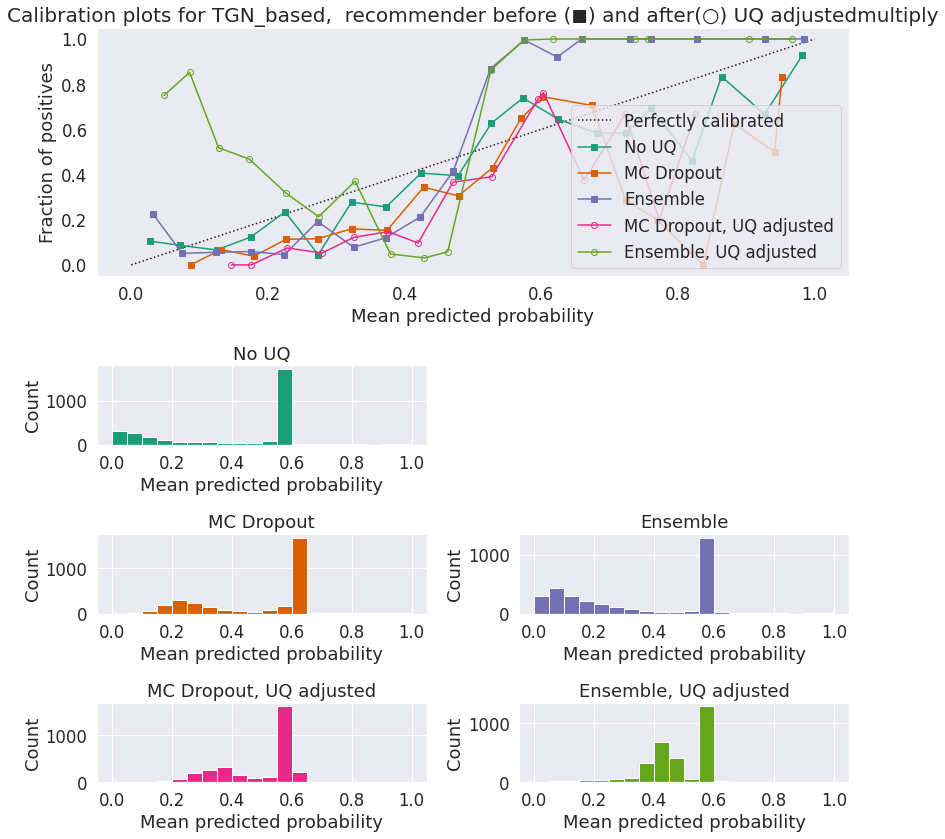

In [25]:
#### after all experiments 

ut.plot_all(args, num =3)
ut.plot_all(args,num = 5)